# Parametric Curve Parameter Estimation (θ, M, X)

This notebook reproduces and explains the full multi-strategy optimization implemented in `parameter_fitting_comprehensive.py`:

- Load `xy_data.csv`
- Define the parametric model and `(u,v)` transform
- Define three residuals: UV-space, Direct-XY, and Hybrid
- Use multiple optimizers: Least Squares, Differential Evolution, Basin Hopping
- Track the best solution by L1 metric on an evenly sampled `t` grid
- Save the best solution to `best_solution.txt` and print a LaTeX-ready string
- Plot diagnostics (transformed space and XY space)



In [2]:
# 1) Imports, config, data load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, differential_evolution, basinhopping
from scipy.spatial.distance import cdist
from datetime import datetime
import time

CSV_PATH = 'xy_data.csv'
BEST_RESULT_FILE = 'best_solution.txt'

# Bounds
THETA_MIN_DEG = 0.001
THETA_MAX_DEG = 50.0
M_MIN = -0.05 + 1e-6
M_MAX = 0.05 - 1e-6
X_MIN = 0.0 + 1e-6
X_MAX = 100.0 - 1e-6

# Uniform t grid for evaluation
T_GRID = np.linspace(6.0, 60.0, 1000)

# Load data
df = pd.read_csv(CSV_PATH)
xy_data = df[['x', 'y']].to_numpy()
print({'num_points': len(xy_data)})



{'num_points': 1500}


In [3]:
# 2) Model and transforms

def model_curve(t, theta_rad, M, X):
    exp_term = np.exp(M * np.abs(t)) * np.sin(0.3 * t)
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    x = t * c - exp_term * s + X
    y = 42.0 + t * s + exp_term * c
    return np.column_stack([x, y])


def transform_to_uv(xy_points, theta_rad, X):
    x = xy_points[:, 0]
    y = xy_points[:, 1]
    x_prime = x - X
    y_prime = y - 42.0
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)
    u = x_prime * c + y_prime * s
    v = -x_prime * s + y_prime * c
    return u, v


def compute_l1_distance(theta_rad, M, X):
    curve_xy = model_curve(T_GRID, theta_rad, M, X)
    distances = cdist(curve_xy, xy_data, metric='cityblock')
    return float(np.mean(np.min(distances, axis=1)))



In [4]:
# 3) Residuals: uv-space, direct-xy, hybrid

def residuals_uv_space(p):
    theta_rad, M, X = p
    u, v = transform_to_uv(xy_data, theta_rad, X)
    pred_v = np.exp(M * u) * np.sin(0.3 * u)
    res = v - pred_v
    # Penalty for u outside [6, 60]
    u_penalty = np.sum(np.clip(6.0 - u, 0, None)**2) + np.sum(np.clip(u - 60.0, 0, None)**2)
    return np.concatenate([res, 0.1 * np.sqrt(u_penalty) * np.ones(1)])


def residuals_direct_xy(p):
    theta_rad, M, X = p
    u, v = transform_to_uv(xy_data, theta_rad, X)
    t_est = np.clip(u, 6.0, 60.0)
    curve_pred = model_curve(t_est, theta_rad, M, X)
    res = xy_data - curve_pred
    return res.flatten()


def residuals_hybrid(p):
    theta_rad, M, X = p
    u, v = transform_to_uv(xy_data, theta_rad, X)
    pred_v = np.exp(M * u) * np.sin(0.3 * u)
    res_uv = v - pred_v
    t_est = np.clip(u, 6.0, 60.0)
    curve_pred = model_curve(t_est, theta_rad, M, X)
    res_xy = (xy_data - curve_pred).flatten()
    return np.concatenate([res_uv * 2.0, res_xy * 0.5])



In [5]:
# 4) Optimizers and helpers

def bounds_array():
    return [
        (np.deg2rad(THETA_MIN_DEG), np.deg2rad(THETA_MAX_DEG)),
        (M_MIN, M_MAX),
        (X_MIN, X_MAX)
    ]


def optimize_least_squares(residual_func, initial_guess, method='lm', loss='linear'):
    try:
        kwargs = {
            'fun': residual_func,
            'x0': initial_guess,
            'method': method,
            'loss': loss,
            'max_nfev': 5000,
            'verbose': 0,
        }
        if method in ['trf', 'dogbox']:
            kwargs['bounds'] = (
                [np.deg2rad(THETA_MIN_DEG), M_MIN, X_MIN],
                [np.deg2rad(THETA_MAX_DEG), M_MAX, X_MAX]
            )
        result = least_squares(**kwargs)
        if method == 'lm':
            params = result.x.copy()
            params[0] = np.clip(params[0], np.deg2rad(THETA_MIN_DEG), np.deg2rad(THETA_MAX_DEG))
            params[1] = np.clip(params[1], M_MIN, M_MAX)
            params[2] = np.clip(params[2], X_MIN, X_MAX)
            return params, result.cost, result.success
        return result.x, result.cost, result.success
    except Exception as e:
        print(f"  Error in least_squares: {e}")
        return None, None, False


def optimize_differential_evolution(residual_func):
    try:
        def objective(p):
            return np.sum(residual_func(p)**2)
        result = differential_evolution(
            objective,
            bounds_array(),
            seed=42,
            maxiter=1000,
            popsize=15,
            atol=1e-8,
            tol=1e-8,
            workers=1
        )
        return result.x, result.fun, result.success
    except Exception as e:
        print(f"  Error in differential_evolution: {e}")
        return None, None, False


def optimize_basin_hopping(residual_func, initial_guess):
    try:
        def objective(p):
            return np.sum(residual_func(p)**2)
        result = basinhopping(
            objective,
            initial_guess,
            niter=100,
            T=1.0,
            stepsize=0.1,
            minimizer_kwargs={'method': 'L-BFGS-B', 'bounds': bounds_array()},
            seed=42
        )
        return result.x, result.fun, result.success
    except Exception as e:
        print(f"  Error in basin_hopping: {e}")
        return None, None, False



In [6]:
# 5) Best-solution tracker

class BestSolutionTracker:
    def __init__(self):
        self.best_l1 = float('inf')
        self.best_params = None
        self.best_method = None
        self.best_residual = None
        self.best_timestamp = None
    
    def evaluate(self, params, method_name, residual_cost):
        if params is None:
            return False
        theta_rad, M, X = params
        if not (np.deg2rad(THETA_MIN_DEG) <= theta_rad <= np.deg2rad(THETA_MAX_DEG)):
            return False
        if not (M_MIN <= M <= M_MAX):
            return False
        if not (X_MIN <= X <= X_MAX):
            return False
        l1_dist = compute_l1_distance(theta_rad, M, X)
        if l1_dist < self.best_l1:
            self.best_l1 = l1_dist
            self.best_params = np.array([theta_rad, M, X], dtype=float)
            self.best_method = method_name
            self.best_residual = residual_cost
            self.best_timestamp = datetime.now().isoformat()
            return True
        return False

    def save_best(self):
        if self.best_params is None:
            print('No best parameters yet.')
            return
        theta_rad, M, X = self.best_params
        theta_deg = np.rad2deg(theta_rad)
        latex = (f"\\left(t*\\cos({theta_rad:.10f})-e^{{{M:.10f}\\left|t\\right|}}\\cdot\\sin(0.3t)\\sin({theta_rad:.10f})+{X:.10f},"
                 f"42+t*\\sin({theta_rad:.10f})+e^{{{M:.10f}\\left|t\\right|}}\\cdot\\sin(0.3t)\\cos({theta_rad:.10f})\\right)")
        report = f"""
================================================================================
BEST SOLUTION FOUND (printed only)
================================================================================
Timestamp: {self.best_timestamp}
Method: {self.best_method}

Parameters:
  theta = {theta_deg:.10f} degrees ({theta_rad:.10f} radians)
  M     = {M:.10f}
  X     = {X:.10f}

Evaluation Metrics:
  L1 Distance (mean): {self.best_l1:.10f}
  Residual Cost:     {self.best_residual:.10e}

LaTeX Submission String:
{latex}

For Desmos Calculator:
Copy the LaTeX string above and paste it into:
https://www.desmos.com/calculator/rfj91yrxob

================================================================================
"""
        # Print instead of saving to file per request
        print(report)
        print('LaTeX:', latex)



In [7]:
# 6) Comprehensive search runner

def generate_initial_guesses(n=20):
    guesses = []
    theta_grid = np.linspace(5, 45, 5)
    M_grid = np.linspace(-0.04, 0.04, 5)
    X_grid = np.linspace(10, 90, 5)
    for theta_deg in theta_grid:
        for M in M_grid:
            for X in X_grid:
                guesses.append([np.deg2rad(theta_deg), M, X])
    np.random.seed(42)
    for _ in range(n):
        theta_deg = np.random.uniform(THETA_MIN_DEG, THETA_MAX_DEG)
        M = np.random.uniform(M_MIN, M_MAX)
        X = np.random.uniform(X_MIN, X_MAX)
        guesses.append([np.deg2rad(theta_deg), M, X])
    return guesses


def run_comprehensive_optimization(max_iterations=None, quick_test=False):
    tracker = BestSolutionTracker()
    n_guesses = 10 if quick_test else 30
    initial_guesses = generate_initial_guesses(n_guesses)
    residual_functions = [
        ("residuals_uv_space", residuals_uv_space),
        ("residuals_direct_xy", residuals_direct_xy),
        ("residuals_hybrid", residuals_hybrid),
    ]
    iteration = 0
    start_time = time.time()
    last_save = start_time

    print("\n=== Starting Optimization ===\n")

    # Test 1: least_squares
    print("[1] least_squares configs...")
    for res_name, residual_func in residual_functions:
        for method in ['lm', 'trf', 'dogbox']:
            losses = ['linear'] if method == 'lm' else ['linear', 'huber', 'soft_l1']
            n_test = 5 if quick_test else 10
            for i, p0 in enumerate(initial_guesses[:n_test]):
                iteration += 1
                method_name = f"{res_name}_{method}_{losses[0]}_init{i}" if len(losses)==1 else None
                for loss in losses:
                    method_name = f"{res_name}_{method}_{loss}_init{i}"
                    params, cost, success = optimize_least_squares(residual_func, p0, method=method, loss=loss)
                    if success and params is not None:
                        if tracker.evaluate(params, method_name, cost):
                            tracker.save_best()
                if max_iterations and iteration >= max_iterations:
                    break
                if (time.time() - last_save) > 30:
                    tracker.save_best(); last_save = time.time()
            if max_iterations and iteration >= max_iterations:
                break
        if max_iterations and iteration >= max_iterations:
            break

    # Test 2: differential evolution
    print("[2] differential_evolution...")
    for res_name, residual_func in residual_functions:
        iteration += 1
        params, cost, success = optimize_differential_evolution(residual_func)
        if success and params is not None and tracker.evaluate(params, f"{res_name}_de", cost):
            tracker.save_best()
        if max_iterations and iteration >= max_iterations:
            break

    # Test 3: basin hopping
    print("[3] basin_hopping...")
    n_bh = 5 if quick_test else 15
    for res_name, residual_func in residual_functions:
        for i, p0 in enumerate(initial_guesses[:n_bh]):
            iteration += 1
            params, cost, success = optimize_basin_hopping(residual_func, p0)
            if success and params is not None and tracker.evaluate(params, f"{res_name}_bh_{i}", cost):
                tracker.save_best()
            if max_iterations and iteration >= max_iterations:
                break
        if max_iterations and iteration >= max_iterations:
            break

    # Refinement
    print("[4] Refinement...")
    if tracker.best_params is not None:
        for res_name, residual_func in residual_functions:
            for method in ['lm', 'trf']:
                iteration += 1
                params, cost, success = optimize_least_squares(residual_func, tracker.best_params, method=method, loss='linear')
                if success and params is not None and tracker.evaluate(params, f"refine_{res_name}_{method}", cost):
                    tracker.save_best()
                if max_iterations and iteration >= max_iterations:
                    break
            if max_iterations and iteration >= max_iterations:
                break

    print("\n=== Done ===\n")
    tracker.save_best()
    return tracker



In [8]:
# 7) Run the search (set quick_test=True for a fast pass)
tracker = run_comprehensive_optimization(max_iterations=None, quick_test=False)

best = tracker.best_params
print('Best params (theta_rad, M, X):', best)
print('Best L1:', tracker.best_l1)
print('Found by:', tracker.best_method)
tracker.save_best()




=== Starting Optimization ===

[1] least_squares configs...

BEST SOLUTION FOUND (printed only)
Timestamp: 2025-11-06T12:34:59.698929
Method: residuals_uv_space_lm_linear_init0

Parameters:
  theta = 13.3989282595 degrees (0.2338554144 radians)
  M     = 0.0124159110
  X     = 10.9930136259

Evaluation Metrics:
  L1 Distance (mean): 21.4497814363
  Residual Cost:     1.7238650303e+04

LaTeX Submission String:
\left(t*\cos(0.2338554144)-e^{0.0124159110\left|t\right|}\cdot\sin(0.3t)\sin(0.2338554144)+10.9930136259,42+t*\sin(0.2338554144)+e^{0.0124159110\left|t\right|}\cdot\sin(0.3t)\cos(0.2338554144)\right)

For Desmos Calculator:
Copy the LaTeX string above and paste it into:
https://www.desmos.com/calculator/rfj91yrxob


LaTeX: \left(t*\cos(0.2338554144)-e^{0.0124159110\left|t\right|}\cdot\sin(0.3t)\sin(0.2338554144)+10.9930136259,42+t*\sin(0.2338554144)+e^{0.0124159110\left|t\right|}\cdot\sin(0.3t)\cos(0.2338554144)\right)

BEST SOLUTION FOUND (printed only)
Timestamp: 2025-11-06T12:

C:\Users\vskav\AppData\Local\Temp\ipykernel_13484\533046180.py:4: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(M * np.abs(t)) * np.sin(0.3 * t)



BEST SOLUTION FOUND (printed only)
Timestamp: 2025-11-06T12:35:06.249898
Method: residuals_direct_xy_dogbox_soft_l1_init1

Parameters:
  theta = 29.9999729323 degrees (0.5235983032 radians)
  M     = 0.0299999969
  X     = 54.9999982132

Evaluation Metrics:
  L1 Distance (mean): 0.0258190855
  Residual Cost:     9.1148253389e-09

LaTeX Submission String:
\left(t*\cos(0.5235983032)-e^{0.0299999969\left|t\right|}\cdot\sin(0.3t)\sin(0.5235983032)+54.9999982132,42+t*\sin(0.5235983032)+e^{0.0299999969\left|t\right|}\cdot\sin(0.3t)\cos(0.5235983032)\right)

For Desmos Calculator:
Copy the LaTeX string above and paste it into:
https://www.desmos.com/calculator/rfj91yrxob


LaTeX: \left(t*\cos(0.5235983032)-e^{0.0299999969\left|t\right|}\cdot\sin(0.3t)\sin(0.5235983032)+54.9999982132,42+t*\sin(0.5235983032)+e^{0.0299999969\left|t\right|}\cdot\sin(0.3t)\cos(0.5235983032)\right)
[2] differential_evolution...

BEST SOLUTION FOUND (printed only)
Timestamp: 2025-11-06T12:35:09.759604
Method: resid

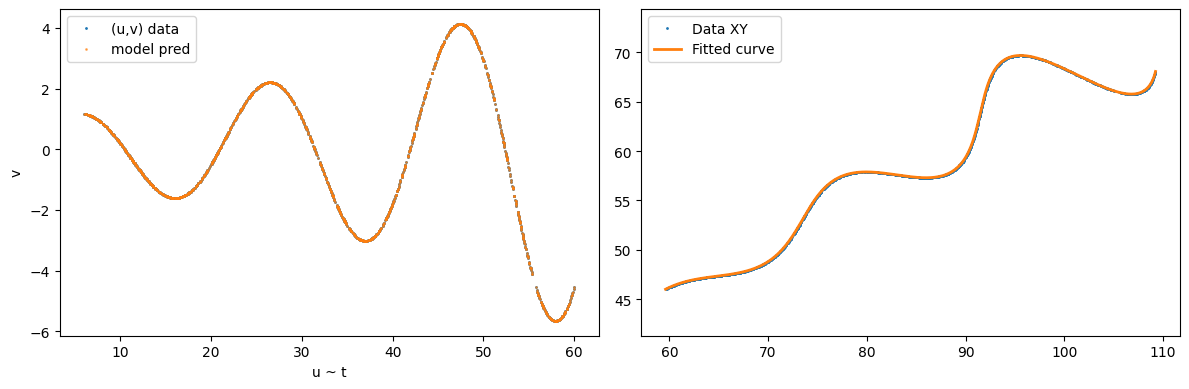

In [9]:
# 8) Diagnostics: plot transformed data vs model and XY curve

theta_hat, M_hat, X_hat = tracker.best_params
u_fit, v_fit = transform_to_uv(xy_data, theta_hat, X_hat)
pred_v = np.exp(M_hat * u_fit) * np.sin(0.3 * u_fit)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(u_fit, v_fit, '.', ms=2, label='(u,v) data')
ax[0].plot(u_fit, pred_v, '.', ms=2, alpha=0.6, label='model pred')
ax[0].set_xlabel('u ~ t')
ax[0].set_ylabel('v')
ax[0].legend()

u_grid = np.linspace(6, 60, 600)
v_grid = np.exp(M_hat * u_grid) * np.sin(0.3 * u_grid)
c = np.cos(theta_hat)
s = np.sin(theta_hat)
x_curve = u_grid * c - v_grid * s + X_hat
y_curve = u_grid * s + v_grid * c + 42.0
ax[1].plot(df['x'], df['y'], '.', ms=2, label='Data XY')
ax[1].plot(x_curve, y_curve, '-', lw=2, label='Fitted curve')
ax[1].set_aspect('equal', adjustable='datalim')
ax[1].legend()
plt.tight_layout()
plt.show()



In [14]:
# 9) Print LaTeX string and approximate L1 on grid pairing by nearest u

latex = (f"\\left(t*\\cos({theta_hat:.6f})-e^{{{M_hat:.6f}\\left|t\\right|}}\\cdot\\sin(0.3t)\\sin({theta_hat:.6f})+{X_hat:.6f},"
         f"42+t*\\sin({theta_hat:.6f})+e^{{{M_hat:.6f}\\left|t\\right|}}\\cdot\\sin(0.3t)\\cos({theta_hat:.6f})\\right)\n")
print('LaTeX submission string:')
print(latex)

# Also print split equations x(t), y(t)
x_tex = (f"x(t)=t\\cos({theta_hat:.6f})-e^{{{M_hat:.6f}\\left|t\\right|}}\\sin(0.3t)\\sin({theta_hat:.6f})+{X_hat:.6f}\n")
y_tex = (f"y(t)=42+t\\sin({theta_hat:.6f})+e^{{{M_hat:.6f}\\left|t\\right|}}\\sin(0.3t)\\cos({theta_hat:.6f}) \n")
print(x_tex)
print(y_tex)

# Approx L1 pairing by nearest u
sort_idx = np.argsort(u_fit)
u_sorted = u_fit[sort_idx]
xy_sorted = xy_data[sort_idx]
nn_idx = np.searchsorted(u_sorted, u_grid, side='left')
nn_idx = np.clip(nn_idx, 0, len(u_sorted) - 1)
xy_nn = xy_sorted[nn_idx]
L1 = np.abs(x_curve - xy_nn[:, 0]) + np.abs(y_curve - xy_nn[:, 1])
print('Approx L1 (mean over grid):', float(np.mean(L1)))



LaTeX submission string:
\left(t*\cos(0.523598)-e^{0.030000\left|t\right|}\cdot\sin(0.3t)\sin(0.523598)+54.999998,42+t*\sin(0.523598)+e^{0.030000\left|t\right|}\cdot\sin(0.3t)\cos(0.523598)\right)

x(t)=t\cos(0.523598)-e^{0.030000\left|t\right|}\sin(0.3t)\sin(0.523598)+54.999998

y(t)=42+t\sin(0.523598)+e^{0.030000\left|t\right|}\sin(0.3t)\cos(0.523598) 

Approx L1 (mean over grid): 0.05215523502857683
